# Wildfire Smoke Controls on Gross Primary Production in Central Canada

## Part 1: Data Scrubbing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# get Sam's stepwise selection function
import statsmodels.api as sm
%run ../lab02/Tutorial_2_2021_functions2.ipynb

# show full dataframes
pd.set_option('max_columns', None)

In [2]:
# get data
data_in = pd.read_csv("drf_timeseries.csv", parse_dates=True, index_col=1).drop("Unnamed: 0", axis=1)

### Select only the relevant months

This study is really only concerned with what goes on between May and September, as the vast majority of primary production (trees photosynthesizing/consuming CO2) and wildfire activity happen in the summer

In [3]:
# select just the growing/wildfire season (may-sept, inclusive)
growing_season = pd.DataFrame()
for month in [5,6,7,8,9]:
    growing_season = growing_season.append(data_in[data_in.index.month == month])

# make sure the data stays in order by date
growing_season = growing_season.sort_values(by="datetime")
growing_season

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),AOD_681nm,AOD_709nm,Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,SH,LE,SLE,G,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,SW_DIF,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,RECO_PI,APAR,PPFD_DIF,FAPAR,ZL
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-08-05 00:00:00,0.0,NaN,0.043281,0.050140,NaN,NaN,0.056433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077186,NaN,NaN,0.084066,NaN,NaN,0.095379,0.109326,0.503352,NaN,NaN,377.728603,0.155769,NaN,16.754,238.260,2.5785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5670,10.3795,0.0,61.7660,94.6780,NaN,NaN,0.7295,NaN,NaN,-38.485,0.000,0.06,NaN,0.000,0.105,335.240,373.680,NaN,NaN,NaN,1.6125,NaN,NaN
2005-08-05 01:00:00,0.0,NaN,0.041713,0.049306,NaN,NaN,0.055380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077047,NaN,NaN,0.083923,NaN,NaN,0.094999,0.110109,0.510514,NaN,NaN,377.707512,0.155787,NaN,16.437,238.760,1.8935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.2685,10.1695,0.0,60.0260,94.6620,NaN,NaN,0.7475,NaN,NaN,-35.440,-0.005,0.19,NaN,0.000,-0.005,334.600,370.220,NaN,NaN,NaN,1.5790,NaN,NaN
2005-08-05 02:00:00,0.0,NaN,0.037905,0.045268,NaN,NaN,0.050330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070703,NaN,NaN,0.075927,NaN,NaN,0.086224,0.100517,0.493424,NaN,NaN,377.680050,0.155811,NaN,16.347,248.315,2.3990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9970,9.9720,0.0,59.3995,94.6285,NaN,NaN,0.7550,17.0,27.47,-30.630,0.000,0.35,NaN,0.000,-0.045,337.985,369.005,NaN,NaN,NaN,1.6050,NaN,NaN
2005-08-05 03:00:00,0.0,NaN,0.034070,0.040381,NaN,NaN,0.044884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063583,NaN,NaN,0.067235,NaN,NaN,0.077404,0.091669,0.470614,NaN,NaN,377.652588,0.155835,NaN,16.077,252.895,1.8860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7580,9.7935,0.0,60.1995,94.5740,NaN,NaN,0.7275,NaN,NaN,-45.005,0.000,0.00,NaN,0.000,-0.120,320.270,365.400,NaN,NaN,NaN,1.5550,NaN,NaN
2005-08-05 04:00:00,0.0,NaN,0.032243,0.038891,NaN,NaN,0.043012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060868,NaN,NaN,0.063953,NaN,NaN,0.075606,0.089504,0.507524,NaN,NaN,377.623732,0.155859,NaN,15.396,232.210,0.8960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5185,9.6225,0.0,60.8120,94.5105,NaN,NaN,0.6855,NaN,NaN,-46.400,0.160,-0.02,NaN,0.005,-0.290,314.705,361.375,NaN,NaN,NaN,1.8040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14 19:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 20:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 21:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Find which measurements have the most complete data

In [4]:
def check_complete(data_in):
    """
    Prints out the percentage of non-NaN values in a dataset
    """
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            print(f"{key}:  {round(completeness,2)} %")
    return None
 

def keep_complete(data_in, thres):
    """
    returns a dataframe that contains a percentage of non-NaNs above
    a specified threshhold
    """
    data_out = pd.DataFrame()
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            if completeness >= thres:
                data_out[key] = data_in[key]
    return data_out

In [5]:
check_complete(growing_season)

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_865nm:  0.0 %
AOD_779nm:  0.0 %
AOD_675nm:  6.44 %
AOD_667nm:  0.0 %
AOD_620nm:  0.0 %
AOD_560nm:  0.0 %
AOD_555nm:  0.0 %
AOD_551nm:  0.0 %
AOD_532nm:  0.0 %
AOD_531nm:  0.0 %
AOD_510nm:  0.0 %
AOD_500nm:  5.51 %
AOD_490nm:  0.0 %
AOD_443nm:  0.0 %
AOD_440nm:  6.32 %
AOD_412nm:  0.0 %
AOD_400nm:  0.0 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
AOD_681nm:  0.0 %
AOD_709nm:  0.0 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
SH:  0.0 %
LE:  34.41 %
SLE:  0.0 %
G:  0.0 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
SW_DIF:  0.0 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
RECO_PI:  4.32 %
AP

Pretty dismal. We need the AOD data, so set a cutoff at 5%. Hopefully we can interpolate the rest

In [6]:
data = keep_complete(growing_season, 5.0)
check_complete(data) # see if that worked

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_675nm:  6.44 %
AOD_500nm:  5.51 %
AOD_440nm:  6.32 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
LE:  34.41 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
PPFD_DIF:  34.87 %


### Interpolation

Now, go through each individual measurement and hand-tune the pandas interpolation scheme to come up with something realistic (If this can't be achieved, toss the whole column). There is a balance here, we are trying to maximize coverage where all columns are finite (not NaNs, so we can perform PCA on as big of dataset as possible), without dangerously extending data beyond what is physical.

#### AOD Data

Physical intuition tells us that smoke events operate on a scale of hours to weeks. We can maybe therefore safely interpolate out to several days before getting into trouble

In [7]:
# get all the AOD columns that survived the purge
aod_list = []
for key in data.keys():
    if "AOD" in key:
        aod_list.append(key)
        print(key)

AOD_1640nm
AOD_1020nm
AOD_870nm
AOD_675nm
AOD_500nm
AOD_440nm
AOD_380nm
AOD_340nm


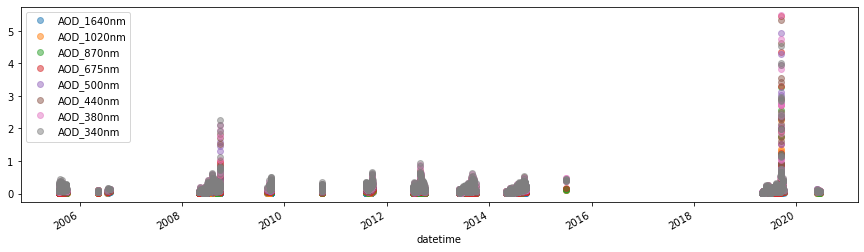

In [8]:
# peek at the raw AOD data. How big of gaps am I willing to try to fill?
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

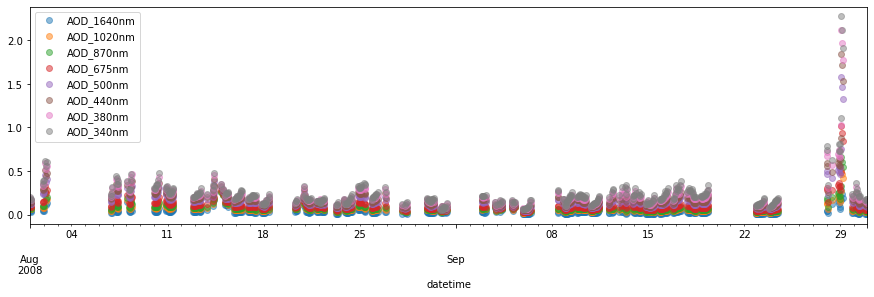

In [9]:
# enhance...
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

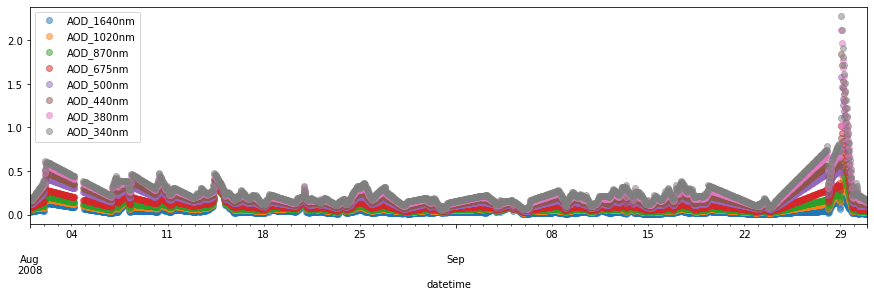

In [10]:
# interpolate with a limit of 48 hour gaps between real data points
data[aod_list] = data[aod_list].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

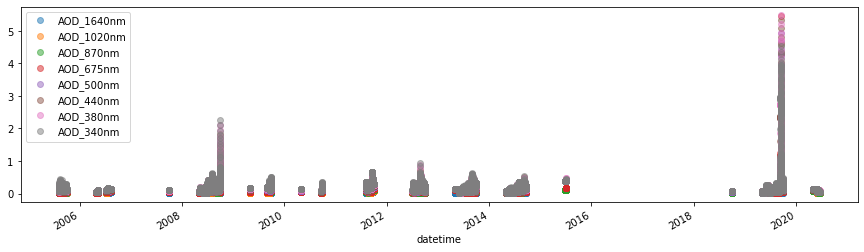

In [11]:
# zoom out again
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

In [12]:
# how much did that help?
check_complete(data[aod_list])

AOD_1640nm:  31.0 %
AOD_1020nm:  35.14 %
AOD_870nm:  36.0 %
AOD_675nm:  35.91 %
AOD_500nm:  31.1 %
AOD_440nm:  35.2 %
AOD_380nm:  36.0 %
AOD_340nm:  35.92 %


48 hours of interpolation will massively increase the amount of viable data (remember, we can't perform PCA on data where *any* of the elements are NaN) while maintaining some sort of realism. What we are implicitly saying here is that we can expect whatever smoke/pollutant/synoptic weather pattern to persist with a timescale of $\approx$ 48 hours (or at least we hope so).

#### Other AERONET Data

- `Precipitable_Water(cm)` total precipitable water in the column
- `Ozone(Dobson)`          calculated ozone concentration
- `NO2(Dobson)`            calculated nitrogen dioxide concentration

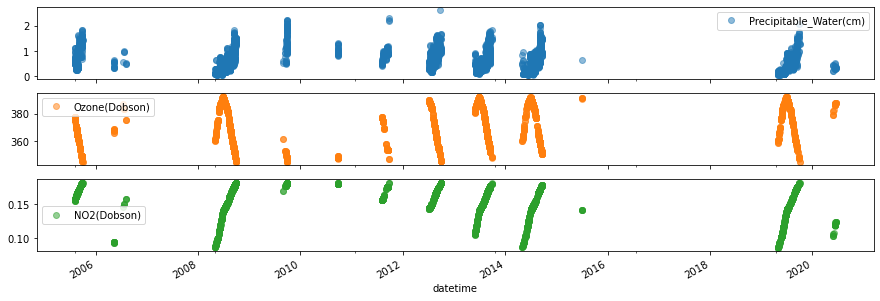

In [13]:
# handle these three much like AOD data above
aeronet = ["Precipitable_Water(cm)", "Ozone(Dobson)", "NO2(Dobson)"]

#fig, ax = plt.subplots(figsize=(15,4))
data[aeronet].plot(marker='o', linestyle="none", alpha=0.5, subplots=True, figsize=(15,5));

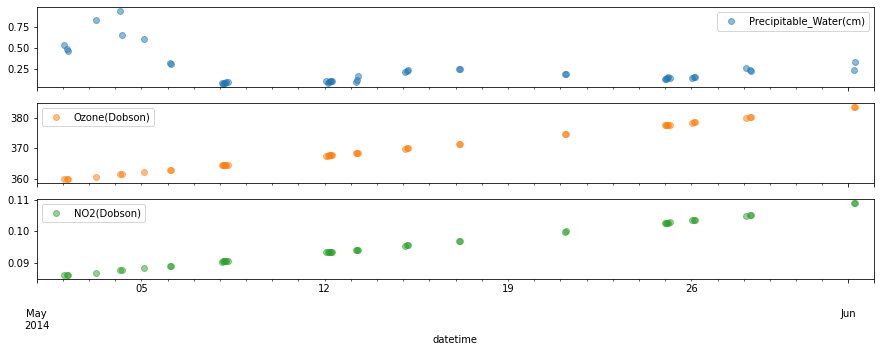

In [14]:
# zoom in on a period of interest (a dense-looking period)
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                              linestyle="none", 
                                              alpha=0.5,
                                              subplots=True, 
                                              figsize=(15,5));

Ozone episodes and precipitable water tend to be regional in scale (Mckendry 1993) and depend on both synoptic and boundary layer meteorology, as well as precursor concentrations (often supplied by wildfires). NO2 is somewhat similar (see Seinfeld and Pandis). Use the same 48 hr interpolation limit as with AOD. (Note: AERONET stations take data several times daily, I'm not sure why this data is so sparse..)

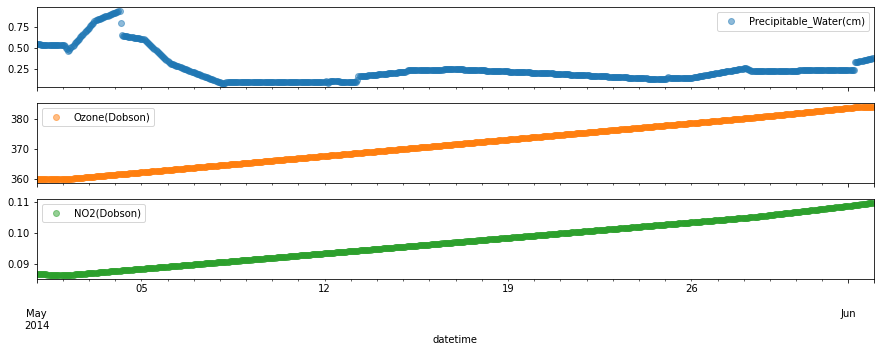

In [15]:
# interpolate with a limit of 48 hour gaps between real data points
data[aeronet] = data[aeronet].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
data[aeronet]['2014-05-01':'2014-06-01'].plot(marker='o',
                                                linestyle="none", 
                                                alpha=0.5,
                                                subplots=True, 
                                                figsize=(15,5));

In [16]:
# check data completeness after interpolation
check_complete(data[aeronet])

Precipitable_Water(cm):  35.91 %
Ozone(Dobson):  36.0 %
NO2(Dobson):  36.0 %


### More Interpolated Variables 

(move on for now)

### Assemble the Final Dataset

In [17]:
# after we finish messing about with interpolations, drop all rows that still have missing data
data_complete = data.dropna()
data

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,LE,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,PPFD_DIF
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-08-05 00:00:00,0.0,NaN,0.043281,0.050140,0.056433,0.077186,0.084066,0.095379,0.109326,0.503352,377.728603,0.155769,NaN,16.754,238.260,2.5785,NaN,NaN,NaN,NaN,NaN,10.5670,10.3795,0.0,61.7660,94.6780,NaN,NaN,0.7295,NaN,NaN,-38.485,0.000,0.06,0.000,0.105,335.240,373.680,NaN,1.6125
2005-08-05 01:00:00,0.0,NaN,0.041713,0.049306,0.055380,0.077047,0.083923,0.094999,0.110109,0.510514,377.707512,0.155787,NaN,16.437,238.760,1.8935,NaN,NaN,NaN,NaN,NaN,10.2685,10.1695,0.0,60.0260,94.6620,NaN,NaN,0.7475,NaN,NaN,-35.440,-0.005,0.19,0.000,-0.005,334.600,370.220,NaN,1.5790
2005-08-05 02:00:00,0.0,NaN,0.037905,0.045268,0.050330,0.070703,0.075927,0.086224,0.100517,0.493424,377.680050,0.155811,NaN,16.347,248.315,2.3990,NaN,NaN,NaN,NaN,NaN,9.9970,9.9720,0.0,59.3995,94.6285,NaN,NaN,0.7550,17.0,27.47,-30.630,0.000,0.35,0.000,-0.045,337.985,369.005,NaN,1.6050
2005-08-05 03:00:00,0.0,NaN,0.034070,0.040381,0.044884,0.063583,0.067235,0.077404,0.091669,0.470614,377.652588,0.155835,NaN,16.077,252.895,1.8860,NaN,NaN,NaN,NaN,NaN,9.7580,9.7935,0.0,60.1995,94.5740,NaN,NaN,0.7275,NaN,NaN,-45.005,0.000,0.00,0.000,-0.120,320.270,365.400,NaN,1.5550
2005-08-05 04:00:00,0.0,NaN,0.032243,0.038891,0.043012,0.060868,0.063953,0.075606,0.089504,0.507524,377.623732,0.155859,NaN,15.396,232.210,0.8960,NaN,NaN,NaN,NaN,NaN,9.5185,9.6225,0.0,60.8120,94.5105,NaN,NaN,0.6855,NaN,NaN,-46.400,0.160,-0.02,0.005,-0.290,314.705,361.375,NaN,1.8040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14 19:00:00,5.0,NaN,0.022221,0.025137,0.031780,NaN,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 20:00:00,5.0,NaN,0.022221,0.025137,0.031780,NaN,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 21:00:00,5.0,NaN,0.022221,0.025137,0.031780,NaN,0.052859,0.062735,0.057933,0.336040,387.701968,0.123415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#######################################################
### choose which version of the dataset to use here ###
#######################################################

data = data_complete

## Part 2: Try PCA 

The basic workflow is:

1) Group by smoke level to generate 4 dataframes

2) Split off outputs (carbon flux data) from the inputs and do PCA

3) Look at the PCs of each regime and compare

In [19]:
# Split the dataset by smoke level, and perform the analysis individually for each
smoke_lvl = data.groupby("smoke")

smoke_dict = {}
for key, value in smoke_lvl:
    smoke_dict[key] = value

### Control Case: No Smoke

In [20]:
data = smoke_dict[0.0]

# separate data into inputs (almost everything) and outputs (CO2 Flux data)
CO2_vars = ["FC", "SC", "NEE_PI"] # note RECO_PI perished in the 5% cutoff purge
outputs = data[CO2_vars]
data = data.drop(CO2_vars, axis=1)
outputs

,FC,SC,NEE_PI
datetime,,,
2007-09-29 06:00:00,5.5330,0.6650,7.0590
2007-09-29 10:00:00,-5.2700,-0.5100,-5.7805
2007-09-29 18:00:00,1.4360,-0.0915,1.3440
2007-09-29 22:00:00,1.0605,0.1870,2.1190
2007-09-30 10:00:00,-2.0400,-0.3555,-2.3960
...,...,...,...
2010-05-01 18:00:00,0.7855,0.1405,0.9255
2010-05-01 22:00:00,1.7190,0.0340,1.7530
2010-05-02 02:00:00,1.0440,0.0340,1.0770


In [21]:
# do PCA
n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

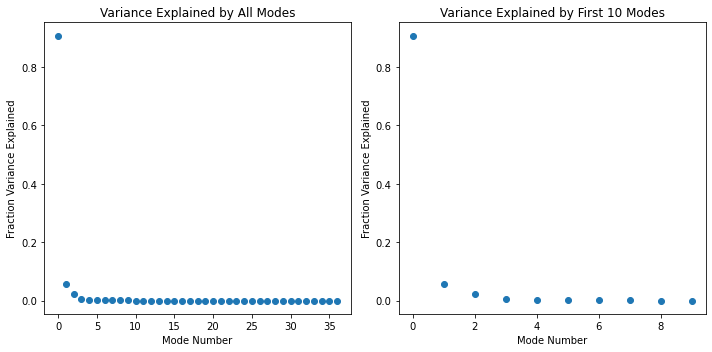

In [22]:
#plot fraction of variance explained by each mode
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

It appears that almost all the variance is contained in the first mode. For the sake of it, lets use the first 4

In [23]:
keep_modes = 4

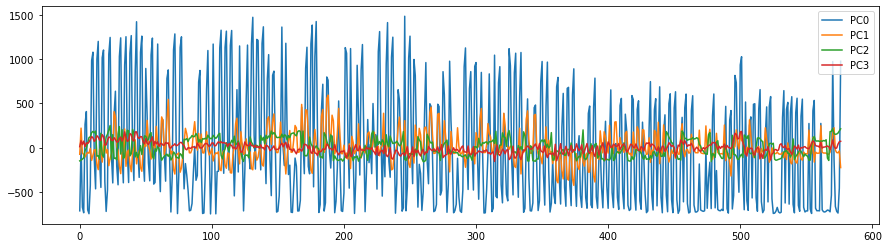

In [28]:
fig, ax = plt.subplots(figsize=(15,4))
for i in range(keep_modes):
    ax.plot(PCs[...,i], label=f"PC{i}")
    #ax.plot(eigvecs[...,i], label=f"PC{i}")
ax.legend()

In [35]:
# Write a function that does this for any of the modes
def do_PCA(data):
    """
    does PCA (future version revise docsting)
    """
    # separate data into inputs (almost everything) and outputs (CO2 Flux data)
    CO2_vars = ["FC", "SC", "NEE_PI"]
    outputs = data[CO2_vars]
    data = data.drop(CO2_vars, axis=1)
    
    n_modes = np.min(np.shape(data))
    pca = PCA(n_components = n_modes)
    PCs = pca.fit_transform(data)
    eigvecs = pca.components_
    fracVar = pca.explained_variance_ratio_
    
    #plot fraction of variance explained by each mode
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.scatter(range(len(fracVar)),fracVar)
    plt.xlabel('Mode Number')
    plt.ylabel('Fraction Variance Explained')
    plt.title('Variance Explained by All Modes')

    plt.subplot(1,2,2)
    n_modes_show = 10
    plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
    plt.xlabel('Mode Number')
    plt.ylabel('Fraction Variance Explained')
    plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

    plt.tight_layout()

    plt.show()
    
    keep_modes = int(input("How many Modes to Retain? "))
    fig, ax = plt.subplots(figsize=(15,4))
    for i in range(keep_modes):
        ax.plot(PCs[...,i], label=f"PC{i}")
        #ax.plot(eigvecs[...,i], label=f"PC{i}")
    ax.legend()
    
    return eigvecs, PCs, outputs

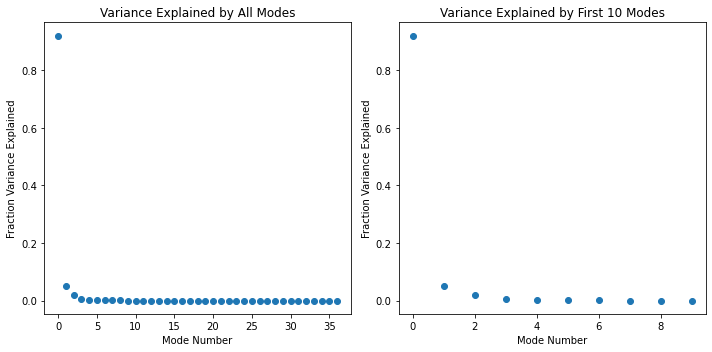

How many Modes to Retain? 4


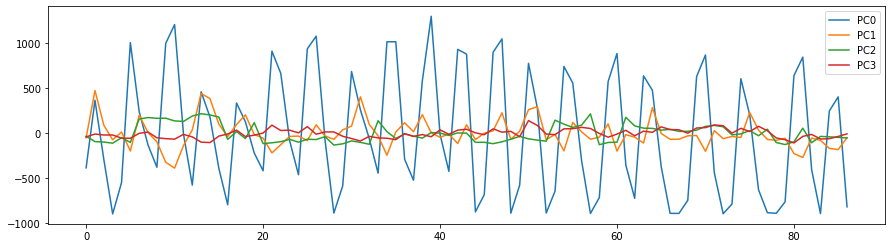

In [36]:
eigvecs1, PCs2, outputs3 = do_PCA(smoke_dict[5.0])

PCA works properly. What are the biggest contributors to the leading modes?

## Multiple Linear Regression

Perform MLR on the PCs to create a predictive model with inputs

**PCs $\rightarrow$ CO2 Fluxes**

or, if we do rotated PCA:

**smoke, PCs $\rightarrow$ CO2 Fluxes**

## 1) MLR with the PCs

In [25]:
# perform MLR with the columns of the PCs
### normalize the PCs first ###
### only use a few PCs
### separate carbon flux outputs ###


# assign predictors and predictands
X = pd.DataFrame(PCs[...,:keep_modes])
Y = outputs["FC"]

# Do MLR
model = LinearRegression().fit(X, Y)
ypred_MLR = model.predict(X)  # y predicted by MLR
#intercept_MLR = model.intercept_[0]  # intercept predicted by MLR
coef_MLR = model.coef_.flatten()  # regression coefficients in MLR model
R2_MLR = model.score(X, Y)  # R-squared value from MLR model

# Display the results
for i, coef in enumerate(coef_MLR):
    print(f"PC{i}: {coef}")

PC0: -0.005504128809799624
PC1: -0.008165683548931085
PC2: 0.002056197666956719
PC3: 0.007598717326124972


Text(0, 0.5, 'modeled Y')

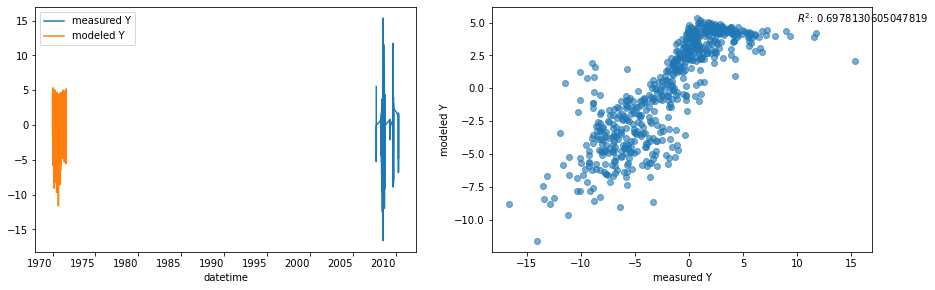

In [26]:
Y_mod = (
#    intercept_MLR
    + (coef_MLR[0] * X[0])
    + (coef_MLR[1] * X[1])
    + (coef_MLR[2] * X[2])
    + (coef_MLR[3] * X[3])
)
fig, ax = plt.subplots(1,2, figsize = (15,5))

Y.plot(ax=ax[0], label="measured Y")
Y_mod.plot(ax=ax[0], label="modeled Y")
#ax[0].set_xlabel("time (arbitrary units)")
ax[0].legend()

ax[1].scatter(Y,Y_mod, alpha=0.6)
ax[1].annotate(f"$R^2$: {R2_MLR}", (10,5))
ax[1].set_xlabel("measured Y")
ax[1].set_ylabel("modeled Y")

## To Do

- Interpolate all columns, eyeball-optimizing between coverage and faithful interpolated values
- chop out dates and outputs, perform PCA on everything else
- try step 2 again, this time grouping on smoke level. Are the leading modes different?


- Try it again with rotated PCA
- Write up the presentation
